In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [2]:
plt.rcParams['lines.linewidth'] = 0.1

import umap

from ceciestunepipe.util.dimension import umapred as dim
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import data as dt


In [3]:
reload(et)
sess_par = {'bird': 's_b1253_21',
           'sess': '2021-06-14',
           'probe': 'probe_0',
           'sort': 2}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

sess_epochs = et.list_sgl_epochs(sess_par)


### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

2021-09-14 15:43:42,904 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx', 'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-14', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-14/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx', 'tmp': '/scratch/earneodo/tmp', 'msort': '/scratch/earneodo/s_b1253_21/sglx/msort/2021-06-14', 'ksort': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14'}, 'files': {'par': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-06-14/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/rig.json', 'kwd': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-06-14/stream.kwd', 'kwik': '/scratch/earneodo/s_b1253_21/sgl

In [5]:
bout_df_path = os.path.join(exp_struct['folders']['derived'], 'bout_df.pkl')
umap_bout_df_path = os.path.join(exp_struct['folders']['derived'], 'bout_df_umap.pkl')

# bout_df.to_pickle(bout_df_path)
# logger.info('saved bout_df to {}'.format(bout_df_path))

bout_df = pd.read_pickle(bout_df_path)
logger.info('loaded bout_df from {}'.format(bout_df_path))

#todo: make a better bout_id
bout_df['bout_id'] = bout_df['start_sample_nidq']

2021-09-14 15:50:04,034 root         INFO     loaded bout_df from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/bout_df.pkl


In [6]:
bout_df.head()

,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,sxx_all,sxx,fr_arr,bout_id
0,313397,470105,37010,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-1308, -1299, -1293, -1277, -1277, -1299, -12...","([312.49576810265256, 351.55773911548414, 390....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.006666666666666667, 0.0, 0.0, 0....",313397
1,1296784,1945211,29739,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-513, -493, -491, -505, -516, -502, -510, -50...","([312.49576810265256, 351.55773911548414, 390....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1296784
2,2220373,3330616,35610,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[2185, 2147, 2129, 2122, 2154, 2135, 2138, 213...","([312.49576810265256, 351.55773911548414, 390....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2220373
3,3589156,5383825,37030,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[331, 327, 327, 343, 361, 351, 361, 363, 346, ...","([312.49576810265256, 351.55773911548414, 390....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3589156
4,5673330,8510137,29449,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-42, -42, -9, -8, -4, 0, -35, 3, 8, -17, -12,...","([312.49576810265256, 351.55773911548414, 390....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5673330


#### show spectrograms

In [ ]:
#show_bout = range(n_show)

show_bout = [1, 5, 13, 27]
n_show = len(show_bout) 
fig, ax = plt.subplots(nrows=n_show, figsize=(16, 4*n_show), sharex=True)

for i_ax, i_bout in enumerate(show_bout):
    ax[i_ax].imshow(np.log(bout_df.iloc[i_bout]['sxx'][::-1]), aspect='auto', cmap='inferno')
    ax[i_ax].set_title('i_bout {}'.format(i_bout))

In [ ]:
umap_win = 50
i_bout = 1

fr = bout_df.iloc[i_bout]['fr_arr']
reducer_fr, emb_fr, frflat = dim.rolling_umap(fr, umap_win, parametric=False, random_state=42)

sx = bout_df.iloc[i_bout]['sxx']
reducer, emb, rxflat = dim.rolling_umap(sx, umap_win, parametric=False, random_state=42)

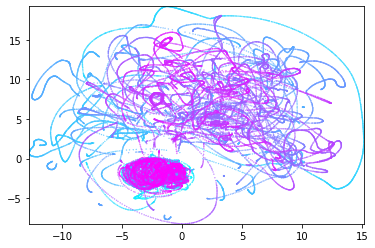

In [9]:
plt.scatter(*emb.T, c=np.arange(emb.shape[0]), s=0.1, cmap='coolwarm');

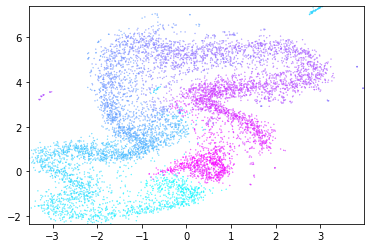

In [10]:
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='coolwarm');

In [11]:
i_bout = 5

fr = bout_df.iloc[i_bout]['fr_arr']
reducer_fr, emb_fr, frflat = dim.rolling_umap(fr, umap_win, parametric=False, random_state=42)

sx = bout_df.iloc[i_bout]['sxx']
reducer, emb, rxflat = dim.rolling_umap(sx, umap_win, parametric=False, random_state=42)

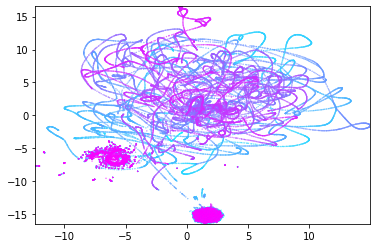

In [12]:
plt.scatter(*emb.T, c=np.arange(emb.shape[0]), s=0.1, cmap='cool');

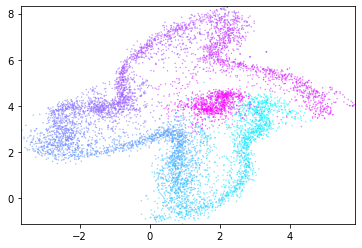

In [13]:
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

In [ ]:
plt.subplots(nrows=n_show, figsize=(16, 4*n_show)

In [5]:
bout_df.head(1)

,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,sxx_all,sxx,fr_arr,bout_id
0,313397,470105,37010,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[473, 447, 466, 489, 520, 563, 660, 658, 612, ...","([312.49576810265256, 351.55773911548414, 390....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",313397


#### make many embeddings

In [5]:
def make_umap_from_sample(bouts_df, feat='sxx', sample_size=0.3, window_size=20, some_bout_id=None):
    # some_bouts_id overrides sample size and uses a particular set of bouts for the embedding
    # pick some bouts
    # get the rolled spectrogram
    # make a umap embedding
    
    all_bout_id = bouts_df['bout_id'].values
    
    if some_bout_id is None:
        some_bout_id = np.random.choice(all_bout_id, int(all_bout_id.size * sample_size), 
                                        replace=False)
    
    bout_sel = bouts_df['bout_id'].isin(some_bout_id)
    
    logger.info('getting rolling {} for {} bouts'.format(feat, some_bout_id.size))
    
    roll_spec = lambda sx: dt.feature_flat(dt.rolling_window(sx, window_size)) 
    
    rolled_feat = 'rolled_' + feat
    bouts_df.loc[bout_sel, rolled_feat] = bouts_df.loc[bout_sel, feat].apply(roll_spec)
    
    logger.info('stacking em up')
    all_rolled_flat_feat = np.hstack(bouts_df.loc[bout_sel, rolled_feat])
    
    logger.info('making the embedding')
    reducer = umap.UMAP(random_state=42, low_memory=True)
    reducer.fit(all_rolled_flat_feat.T)
    logger.info('done')
    return reducer


def project_bouts(bouts_df, some_bout_id, reducer, window_size=20, feat='sxx'):
    ## do the rolling spectrogram and project for all of the some_bout_id
    bout_sel = bouts_df['bout_id'].isin(some_bout_id)
    
    logger.info('getting rolling {} umap projections for {} bouts'.format(feat, some_bout_id.size))
    roll_umap = lambda sx: dim.rolling_umap(sx, window_size, reducer)[1]
    
    logger.info('applying and making column rolled_umap_{}'.format(feat))
    bouts_df.loc[bout_sel, 'rolled_umap_{}'.format(feat)] = bouts_df.loc[bout_sel, feat].apply(roll_umap)
    bouts_df.loc[bout_sel, 'has_umap_'.format(feat)] = True
    
    return bouts_df

### pick these two particular bouts

In [6]:
bout_i_list = [1, 5, 13]
bout_id_list = [bout_df.iloc[i]['bout_id'] for i in bout_i_list]

In [7]:
### pick a random sample of bouts
umap_win = 50
n_sample = 2

#all_bout_id = bout_df['bout_id'].values

id_some_bout = np.array(bout_id_list)
#id_some_bout = np.random.choice(all_bout_id, n_sample, replace=False)

### make the projection with just this set of bouts
feature = 'sxx' # 'sxx' spectrogram, 'fr_arr' for firing rate. Both come in ms time step.

## save/load the reducer
reducer_path = os.path.join(exp_struct['folders']['derived'], 'reducer_{}.pkl'.format(feature))

sx_reducer = make_umap_from_sample(bout_df, some_bout_id=id_some_bout, window_size=umap_win)

with open(reducer_path, 'wb') as f:
    pickle.dump(sx_reducer, f)
logger.info('saved {} reducer to {}'.format(feature, reducer_path))
    
## or alternatively load reducer

2021-08-19 14:31:06,469 root         INFO     getting rolling sxx for 3 bouts
2021-08-19 14:31:07,999 root         INFO     stacking em up
2021-08-19 14:31:14,028 root         INFO     making the embedding
2021-08-19 14:44:12,959 root         INFO     done


In [20]:
feature = 'sxx'
reducer_path = os.path.join(exp_struct['folders']['derived'], 'reducer_{}.pkl'.format(feature))
reducer_path

'/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/reducer_sxx.pkl'

In [8]:
bout_df = project_bouts(bout_df, id_some_bout, sx_reducer, window_size=umap_win)

2021-08-19 14:44:12,996 root         INFO     getting rolling sxx umap projections for 3 bouts
2021-08-19 14:44:12,997 root         INFO     applying and making column rolled_umap_sxx
/home/earneodo/anaconda3/envs/unepipe/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [9]:
feature = 'fr_arr' # 'sxx' spectrogram, 'fr_arr' for firing rate. Both come in ms time step.
reducer_path = os.path.join(exp_struct['folders']['derived'], 'reducer_{}.pkl'.format(feature))

# maybe load reducer instead of computing it
fr_reducer = make_umap_from_sample(bout_df, feat=feature, some_bout_id=id_some_bout, window_size=umap_win)

#save reducer
with open(reducer_path, 'wb') as f:
    pickle.dump(fr_reducer, f)
logger.info('saved {} reducer to {}'.format(feature, reducer_path))


bout_df = project_bouts(bout_df, id_some_bout, fr_reducer, window_size=umap_win, feat=feature)

2021-08-19 15:47:06,537 root         INFO     getting rolling fr_arr for 3 bouts
2021-08-19 15:47:06,689 root         INFO     stacking em up
2021-08-19 15:47:06,941 root         INFO     making the embedding
2021-08-19 15:47:37,180 root         INFO     done
2021-08-19 15:47:37,186 root         INFO     getting rolling fr_arr umap projections for 3 bouts
2021-08-19 15:47:37,187 root         INFO     applying and making column rolled_umap_fr_arr


In [26]:
### load/save the bouts with projected umap

In [25]:

bout_df.to_pickle(umap_bout_df_path)
logger.info('saved bout_df to {}'.format(umap_bout_df_path))

2021-08-25 13:11:22,410 root         INFO     saved bout_df to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/bout_df_umap.pkl


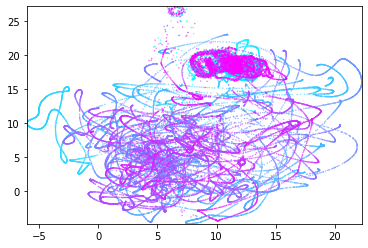

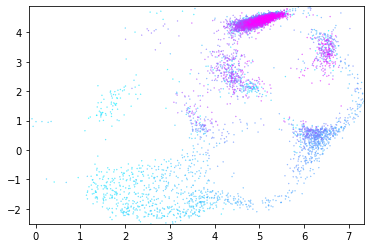

In [15]:
the_bout = bout_df.loc[bout_df['bout_id']==bout_id_list[0]]

emb_sx = the_bout['rolled_umap_sxx'].values[0]
emb_fr = the_bout['rolled_umap_fr_arr'].values[0]

plt.scatter(*emb_sx.T, c=np.arange(emb_sx.shape[0]), s=0.1, cmap='cool');
plt.figure()
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

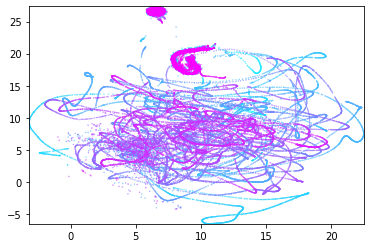

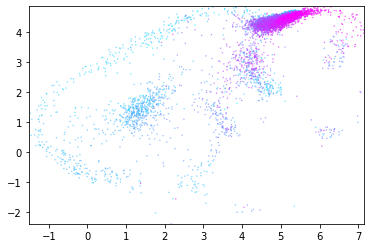

In [17]:
the_bout = bout_df.loc[bout_df['bout_id']==bout_id_list[1]]

emb_sx = the_bout['rolled_umap_sxx'].values[0]
emb_fr = the_bout['rolled_umap_fr_arr'].values[0]

plt.scatter(*emb_sx.T, c=np.arange(emb_sx.shape[0]), s=0.1, cmap='cool');
plt.figure()
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

In [18]:
the_bout = bout_df.loc[bout_df['bout_id']==bout_id_list[2]]

emb_sx = the_bout['rolled_umap_sxx'].values[0]
emb_fr = the_bout['rolled_umap_fr_arr'].values[0]

plt.scatter(*emb_sx.T, c=np.arange(emb_sx.shape[0]), s=0.1, cmap='cool');
plt.figure()
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

IndexError: list index out of range

In [ ]:
emb_fr = the_bout['rolled_umap_fr_arr'].values[0]
plt.scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='cool');

In [21]:
for bout_id in bout_id_list:
    the_bout = bout_df.loc[bout_df['bout_id']==bout_id]
    
    bout_df.loc[bout_df['bout_id']][]

,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,sxx_all,sxx,fr_arr,bout_id,rolled_sxx,rolled_umap_sxx,has_umap_
0,313397,470105,37010,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-1308, -1299, -1293, -1277, -1277, -1299, -12...","([312.49576810265256, 351.55773911548414, 390....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[0.0, 0.0, 0.006666666666666667, 0.0, 0.0, 0....",313397,NaN,NaN,NaN


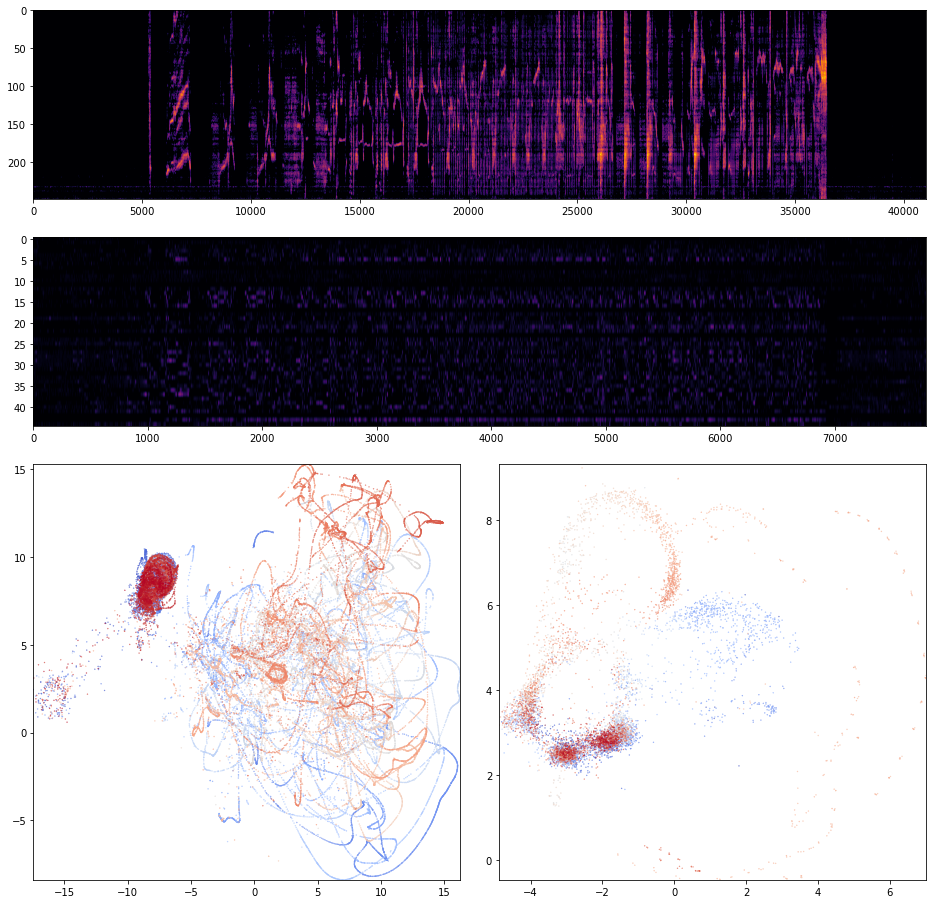

In [15]:
def show_bout(bout_df, bout_id, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(16, 16))
        gs = fig.add_gridspec(4, 4)
        ax = []
        ax.append(fig.add_subplot(gs[0, :]))
        ax.append(fig.add_subplot(gs[1, :]))
        ax.append(fig.add_subplot(gs[2:, :2]))
        ax.append(fig.add_subplot(gs[2:, 2:]))
    
        
    the_bout = bout_df.loc[bout_df['bout_id']==bout_id]

    sx = the_bout['sxx'].values[0]
    emb_sx = the_bout['rolled_umap_sxx'].values[0]
    emb_fr = the_bout['rolled_umap_fr_arr'].values[0]

    ax[0].imshow(np.log(the_bout['sxx'].values[0][::-1]), aspect='auto', cmap='inferno');
    ax[1].imshow((the_bout['fr_arr'].values[0][::-1]), aspect='auto', cmap='inferno');
    
    ax[2].scatter(*emb_sx.T, c=np.arange(emb_sx.shape[0]), s=0.1, cmap='coolwarm');
    ax[3].scatter(*emb_fr.T, c=np.arange(emb_fr.shape[0]), s=0.1, cmap='coolwarm');
                           
    return ax
                           
show_bout(bout_df, bout_id_list[0])

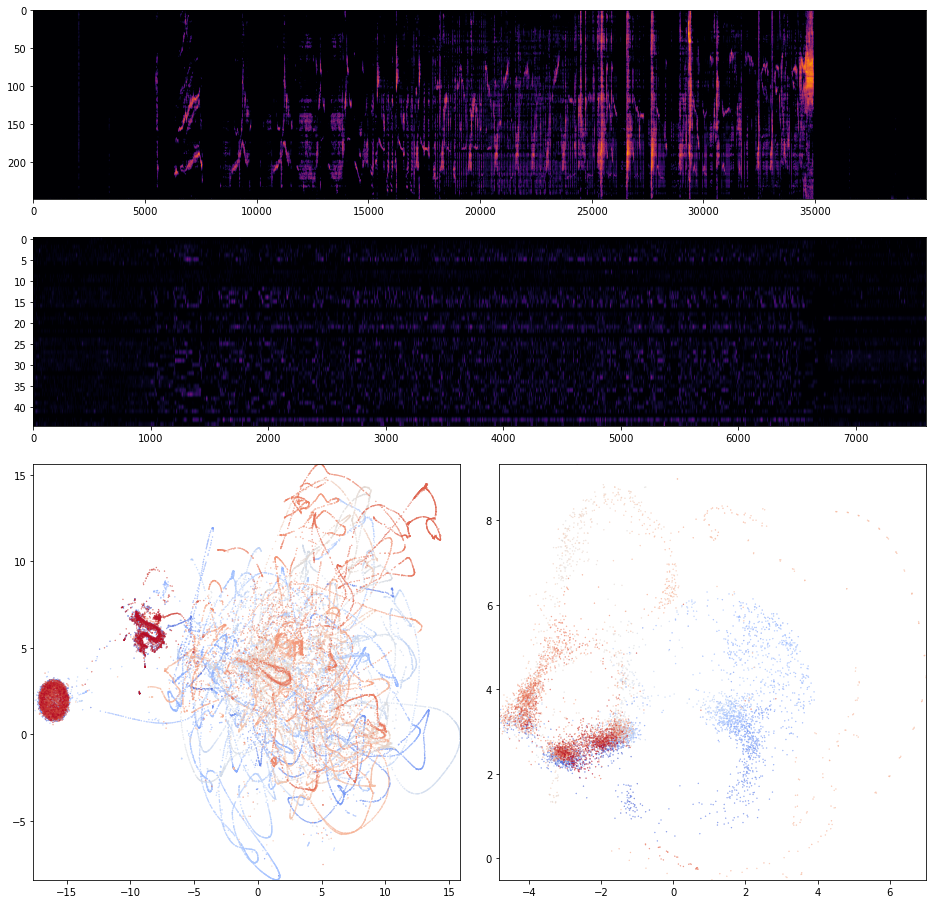

In [16]:
show_bout(bout_df, bout_id_list[1])

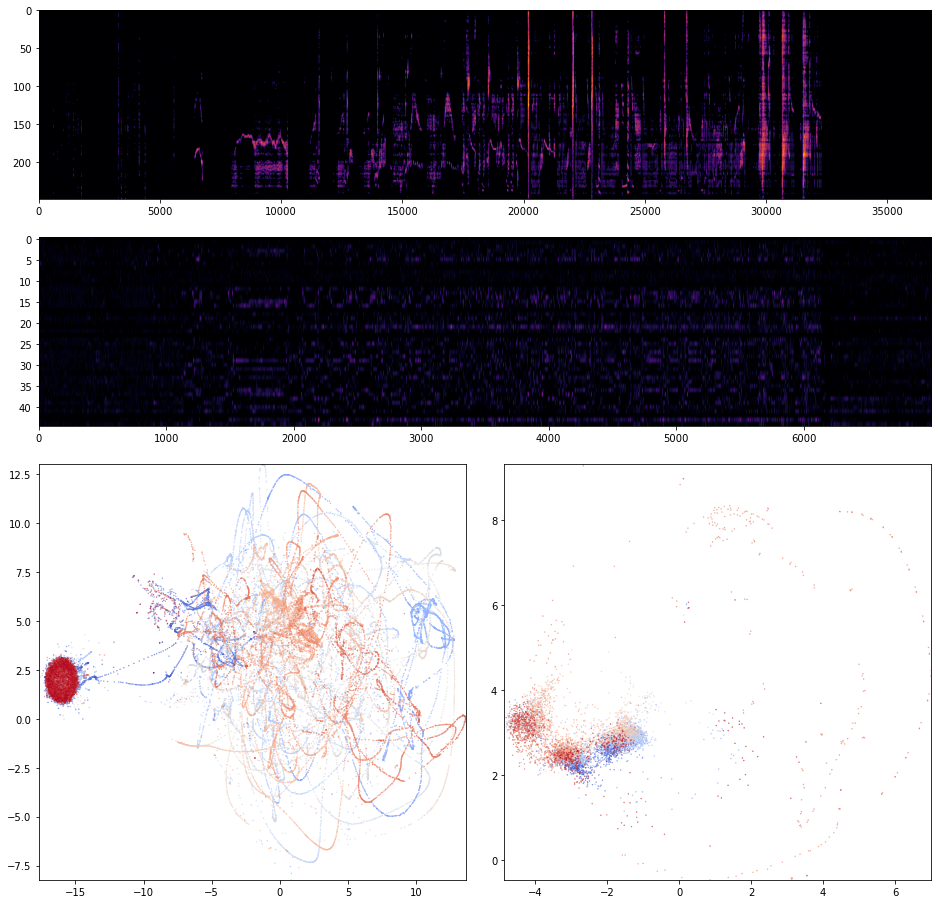

In [17]:
show_bout(bout_df, bout_id_list[2])

In [ ]:


# Topics: line, color, LineCollection, cmap, colorline, codex
'''
Defines a function colorline that draws a (multi-)colored 2D line with coordinates x and y.
The color is taken from optional data in z, and creates a LineCollection.

z can be:
- empty, in which case a default coloring will be used based on the position along the input arrays
- a single number, for a uniform color [this can also be accomplished with the usual plt.plot]
- an array of the length of at least the same length as x, to color according to this data
- an array of a smaller length, in which case the colors are repeated along the curve

The function colorline returns the LineCollection created, which can be modified afterwards.

See also: plt.streamplot
'''

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


# Data manipulation:

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments


# Interface to LineCollection:

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc
        
    
def clear_frame(ax=None): 
    # Taken from a post by Tony S Yu
    if ax is None: 
        ax = plt.gca() 
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False) 
    for spine in ax.spines.itervalues(): 
        spine.set_visible(False) 



In [ ]:
sx.shape

In [ ]:
emb.shape

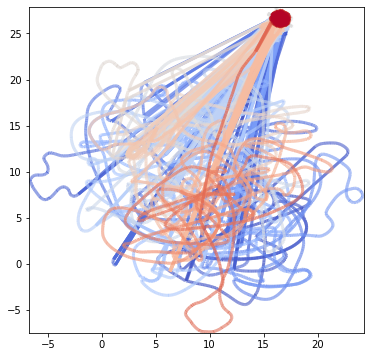

In [38]:
t = np.arange(emb.shape[0])

x = emb.T[0]
y = emb.T[1]

fig, axes = plt.subplots(figsize=(6,6))

lc = colorline(x, y, alpha=0.75, cmap='coolwarm') 
# We can capture the LineCollection created to modify it later, e.g.:
# lc.set_rasterized = False

plt.xlim(x.min() - 0.1, x.max() + 0.1)
plt.ylim(y.min() - 0.1, y.max() + 0.1)

# plt.colorbar()  # Does not work at the moment!
plt.show()

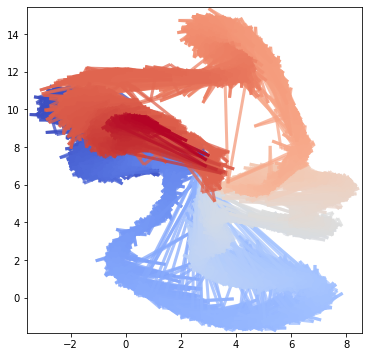

In [39]:
t = np.arange(emb.shape[0])

x = emb_fr.T[0]
y = emb_fr.T[1]

fig, axes = plt.subplots(figsize=(6,6))

lc = colorline(x, y, alpha=0.75, cmap='coolwarm') 
# We can capture the LineCollection created to modify it later, e.g.:
# lc.set_rasterized = False

plt.xlim(x.min() - 0.1, x.max() + 0.1)
plt.ylim(y.min() - 0.1, y.max() + 0.1)

# plt.colorbar()  # Does not work at the moment!
plt.show()

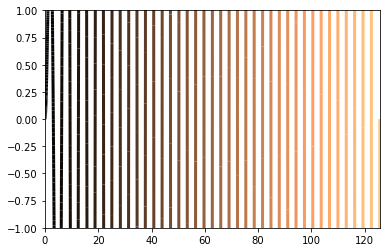

In [18]:
x = np.linspace(0, 40.*np.pi, 10000)
y = np.sin(x)*x

fig, axes = plt.subplots()

colorline(x, y)

plt.xlim(x.min(), x.max())
plt.ylim(-1.0, 1.0)
plt.show()